# Intro

Parameters are basically all weights and biases. Parameters are not set by us, parameters are calculated automatically by backprop.

Metaparameters (or Hyperparameters) are parameters set by us, they are hardcoded - and that's the biggest challenge in deep learning to find out which metaparameters will work best with our model.

Metaparameters are:

* Model Architecture
* Number of Hidden Layers
* Number of Units per Layer
* Cross-validation sizes
* Mini-batch size
* Activation functions
* Optimization functions
* Learning Rate
* Dropout
* Loss function
* Data normalization
* Weight normalization
* Weight initialization
* etc

It's simply impossible to search the entire metaparameters space. Therefore, it's difficult to be sure that we're using the best metaparams setup. However, parameteric experiments are feasible on some metaprameters.

# Data

In [2]:
import pandas as pd

import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import time

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
                 sep = ';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.shape

(1599, 12)

In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


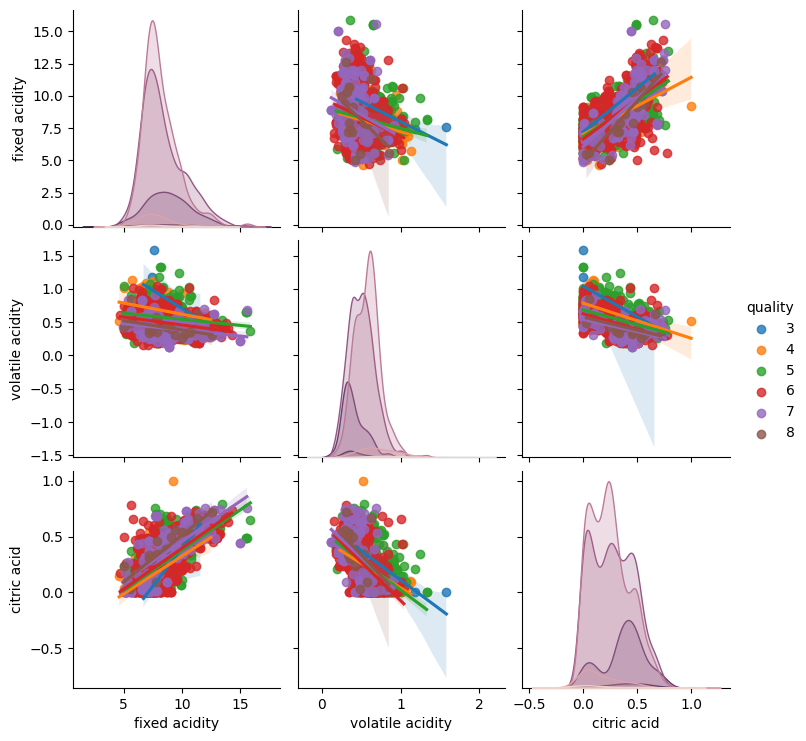

In [6]:
cols_2_plot = ['fixed acidity', 'volatile acidity', 'citric acid', 'quality']
sns.pairplot(df[cols_2_plot], kind = 'reg', hue = 'quality')

/tmp/ipython-input-2444677833.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


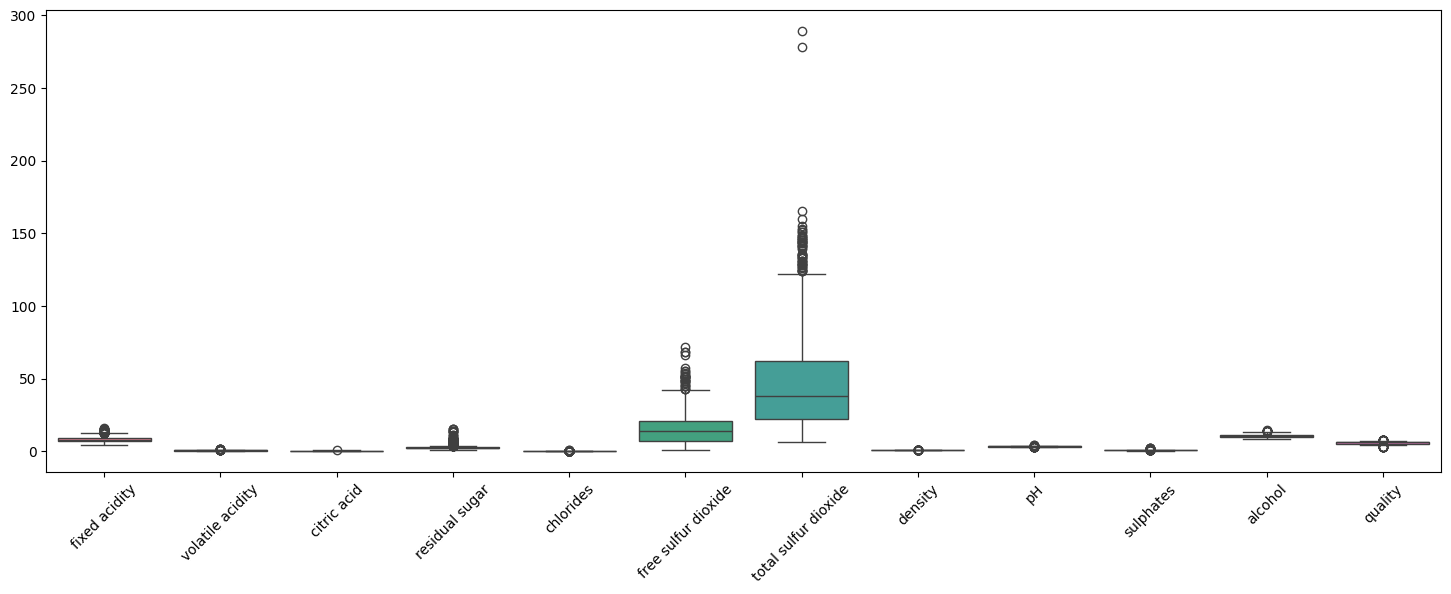

In [ ]:
fig, ax = plt.subplots(1, figsize = (18, 6))

ax = sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

Now let's apply z-score to all vars but target (quality)

/tmp/ipython-input-1455282660.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


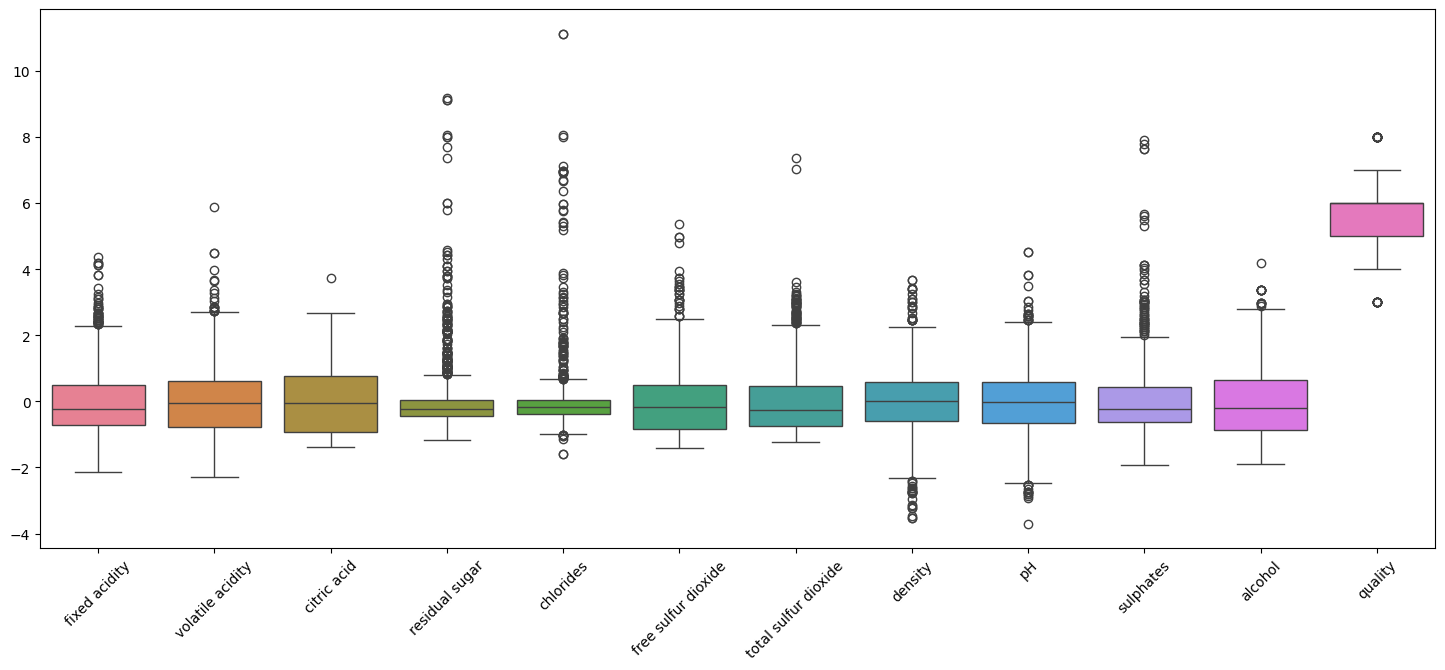

In [ ]:
cols_2_zscore = df.keys().drop('quality')
df[cols_2_zscore] = df[cols_2_zscore].apply(stats.zscore)

fig, ax = plt.subplots(1, figsize = (18, 7))

ax = sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

Text(0, 0.5, 'Counts')

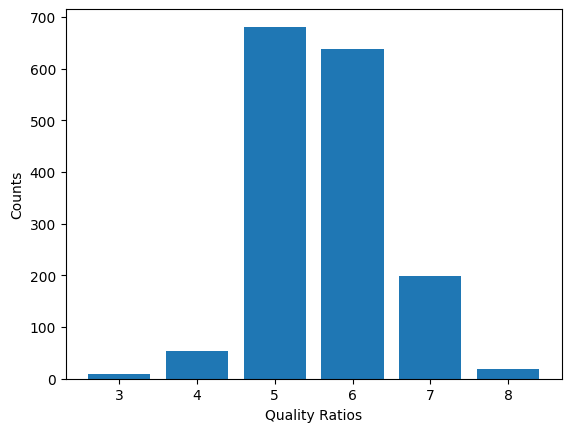

In [ ]:
plt.bar(df['quality'].value_counts().keys(), list(df['quality'].value_counts()))
plt.xlabel('Quality Ratios')
plt.ylabel('Counts')

Since we have huge gaps - over- and under-representation of some values we're going to create bool_quality value.

In [ ]:
df['bool_quality'] = 0
df['bool_quality'].loc[df['quality'] > 5] = 1
df['bool_quality'].value_counts()

/tmp/ipython-input-112607636.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['bool_quality'].loc[df['quality'] > 5] = 1
/tmp/ipython-input-112607636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,count
bool_quality,
1,855
0,744


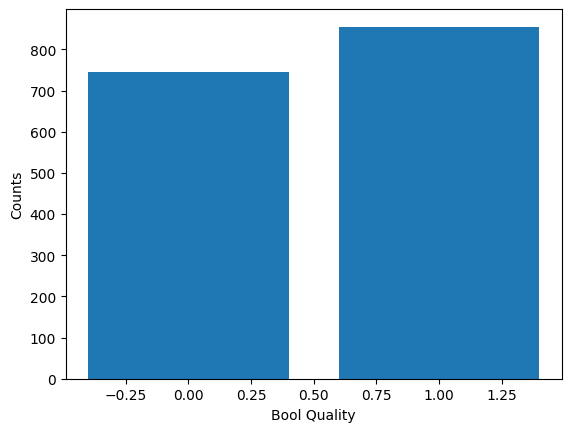

In [ ]:
plt.bar(df['bool_quality'].value_counts().keys(), list(df['bool_quality'].value_counts()))
plt.xlabel('Bool Quality')
plt.ylabel('Counts')
plt.show()

In [ ]:
data = torch.tensor(df[cols_2_zscore].values).float()
labels = torch.tensor(df['bool_quality'].values).float()

data.shape, labels.shape

(torch.Size([1599, 11]), torch.Size([1599]))

In [ ]:
labels = labels[:, None]
data.shape, labels.shape

(torch.Size([1599, 11]), torch.Size([1599, 1]))

# Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = .8)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

def train_dataloader_fn(batch_size):
  train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)
  return train_dataloader

test_dataloader = DataLoader(test_dataset, batch_size = X_train.shape[0])

In [ ]:
for X, y in train_dataloader_fn(64):
  print(X.shape, y.shape)

torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])


# Model Arch

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(11, 16)

    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    self.output = nn.Linear(32, 1)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)

    x = self.output(x)

    return x

# Model Setup

In [ ]:
def ModelSetup():
  ann = Model()
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-3)

  return ann, loss_fn, optimizer

# Model Train

In [ ]:
def ModelTrain(batch_size, epochs):
  train_dataloader = train_dataloader_fn(batch_size)
  ann, loss_fn, optimizer = ModelSetup()

  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)
  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataloader))
    batch_accs = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):
      batch_y_hat = ann(X_train)

      batch_loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = batch_loss

      pred = (batch_y_hat.squeeze(1) >= 0).long()
      targ = y_train.squeeze(1).long()
      batch_acc = 100 * (pred == targ).float().mean()
      batch_accs[batch] = batch_acc

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()


    train_losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    ann.eval()

    X_test, y_test = next(iter(test_dataloader))
    test_y_hat = ann(X_test)

    test_loss = loss_fn(test_y_hat, y_test)
    test_losses[epoch] = test_loss

    pred = (test_y_hat.squeeze(1) >= 0).long()
    targ = y_test.squeeze(1).long()
    test_acc = 100 * (pred == targ).float().mean()
    test_accs[epoch] = test_acc

    if epoch%10 == 0:
      print(f'Epoch: {epoch} | Train -> Acc: {train_accs[epoch]:2f} Loss: {train_losses[epoch]:2f} | Test -> Acc: {test_acc:2f} Loss: {test_loss:2f}')

  return train_losses, train_accs, test_losses, test_accs

# Model Run

In [ ]:
train_losses, train_accs, test_losses, test_accs = ModelTrain(batch_size = 64, epochs = 500)

Epoch: 0 | Train -> Acc: 53.289474 Loss: 0.690588 | Test -> Acc: 55.624996 Loss: 0.688827
Epoch: 10 | Train -> Acc: 53.782894 Loss: 0.689516 | Test -> Acc: 55.312504 Loss: 0.687896
Epoch: 20 | Train -> Acc: 53.289474 Loss: 0.689103 | Test -> Acc: 55.312504 Loss: 0.687024
Epoch: 30 | Train -> Acc: 52.878288 Loss: 0.688661 | Test -> Acc: 55.624996 Loss: 0.686219
Epoch: 40 | Train -> Acc: 52.960526 Loss: 0.688216 | Test -> Acc: 55.624996 Loss: 0.685458
Epoch: 50 | Train -> Acc: 53.453949 Loss: 0.686977 | Test -> Acc: 55.312504 Loss: 0.684719
Epoch: 60 | Train -> Acc: 53.042763 Loss: 0.686837 | Test -> Acc: 55.312504 Loss: 0.684002
Epoch: 70 | Train -> Acc: 53.618420 Loss: 0.685600 | Test -> Acc: 55.312504 Loss: 0.683289
Epoch: 80 | Train -> Acc: 53.125000 Loss: 0.685491 | Test -> Acc: 55.312504 Loss: 0.682580
Epoch: 90 | Train -> Acc: 52.960526 Loss: 0.685039 | Test -> Acc: 55.312504 Loss: 0.681906
Epoch: 100 | Train -> Acc: 53.371712 Loss: 0.683983 | Test -> Acc: 55.312504 Loss: 0.681218

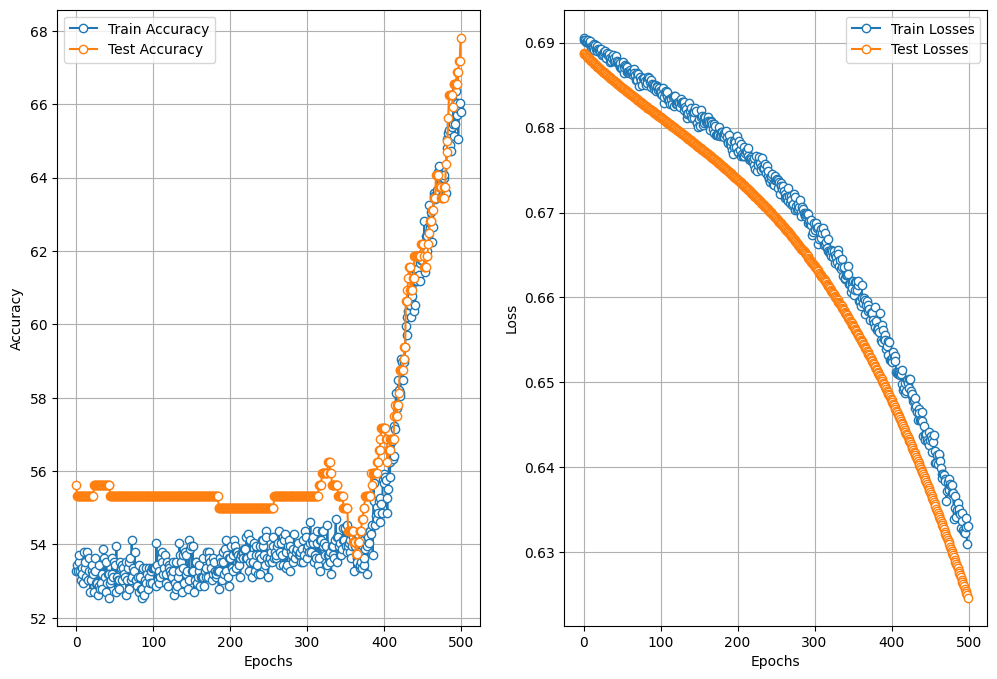

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 8))

ax[0].plot(train_accs, '-o', markerfacecolor = 'w', label = 'Train Accuracy')
ax[0].plot(test_accs, '-o', markerfacecolor = 'w', label = 'Test Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid()

ax[1].plot(train_losses.detach(), '-o', markerfacecolor = 'w', label = 'Train Losses')
ax[1].plot(test_losses.detach(), '-o', markerfacecolor = 'w', label = 'Test Losses')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid()

plt.show()

# Batch Size Experiment

In [ ]:
batch_sizes = [2**i for i in range(1, 7)]
epochs = 1000

exp_train_accs = torch.zeros(epochs, len(batch_sizes))
exp_test_accs = torch.zeros(epochs, len(batch_sizes))
exp_train_losses = torch.zeros(epochs, len(batch_sizes))
exp_test_losses = torch.zeros(epochs, len(batch_sizes))

exp_times = torch.zeros(len(batch_sizes))

for idx_batch_size in range(len(batch_sizes)):


  print(f'PROCESSING batch_size: {batch_sizes[idx_batch_size]}')

  start_time = time.process_time()
  train_losses, train_accs, test_losses, test_accs = ModelTrain(batch_size = batch_sizes[idx_batch_size], epochs = epochs)
  end_time = time.process_time()
  exp_times[idx_batch_size] = end_time - start_time

  exp_train_accs[:, idx_batch_size] = train_accs
  exp_test_accs[:, idx_batch_size] = test_accs
  exp_train_losses[:, idx_batch_size] = train_losses
  exp_test_losses[:, idx_batch_size] = test_losses

PROCESSING batch_size: 2
Epoch: 0 | Train -> Acc: 46.875000 Loss: 0.698101 | Test -> Acc: 45.312500 Loss: 0.698278
Epoch: 10 | Train -> Acc: 47.121712 Loss: 0.696376 | Test -> Acc: 46.250000 Loss: 0.696647
Epoch: 20 | Train -> Acc: 48.601974 Loss: 0.695384 | Test -> Acc: 47.812500 Loss: 0.695116
Epoch: 30 | Train -> Acc: 50.164474 Loss: 0.694559 | Test -> Acc: 50.625004 Loss: 0.693771
Epoch: 40 | Train -> Acc: 52.220394 Loss: 0.693570 | Test -> Acc: 53.125000 Loss: 0.692498
Epoch: 50 | Train -> Acc: 53.865131 Loss: 0.692860 | Test -> Acc: 54.062496 Loss: 0.691345
Epoch: 60 | Train -> Acc: 55.592106 Loss: 0.691640 | Test -> Acc: 56.250000 Loss: 0.690295
Epoch: 70 | Train -> Acc: 55.674343 Loss: 0.690815 | Test -> Acc: 58.749996 Loss: 0.689295
Epoch: 80 | Train -> Acc: 56.496712 Loss: 0.690097 | Test -> Acc: 60.312496 Loss: 0.688354
Epoch: 90 | Train -> Acc: 56.332237 Loss: 0.689777 | Test -> Acc: 59.375000 Loss: 0.687443
Epoch: 100 | Train -> Acc: 55.674343 Loss: 0.688998 | Test -> Acc:

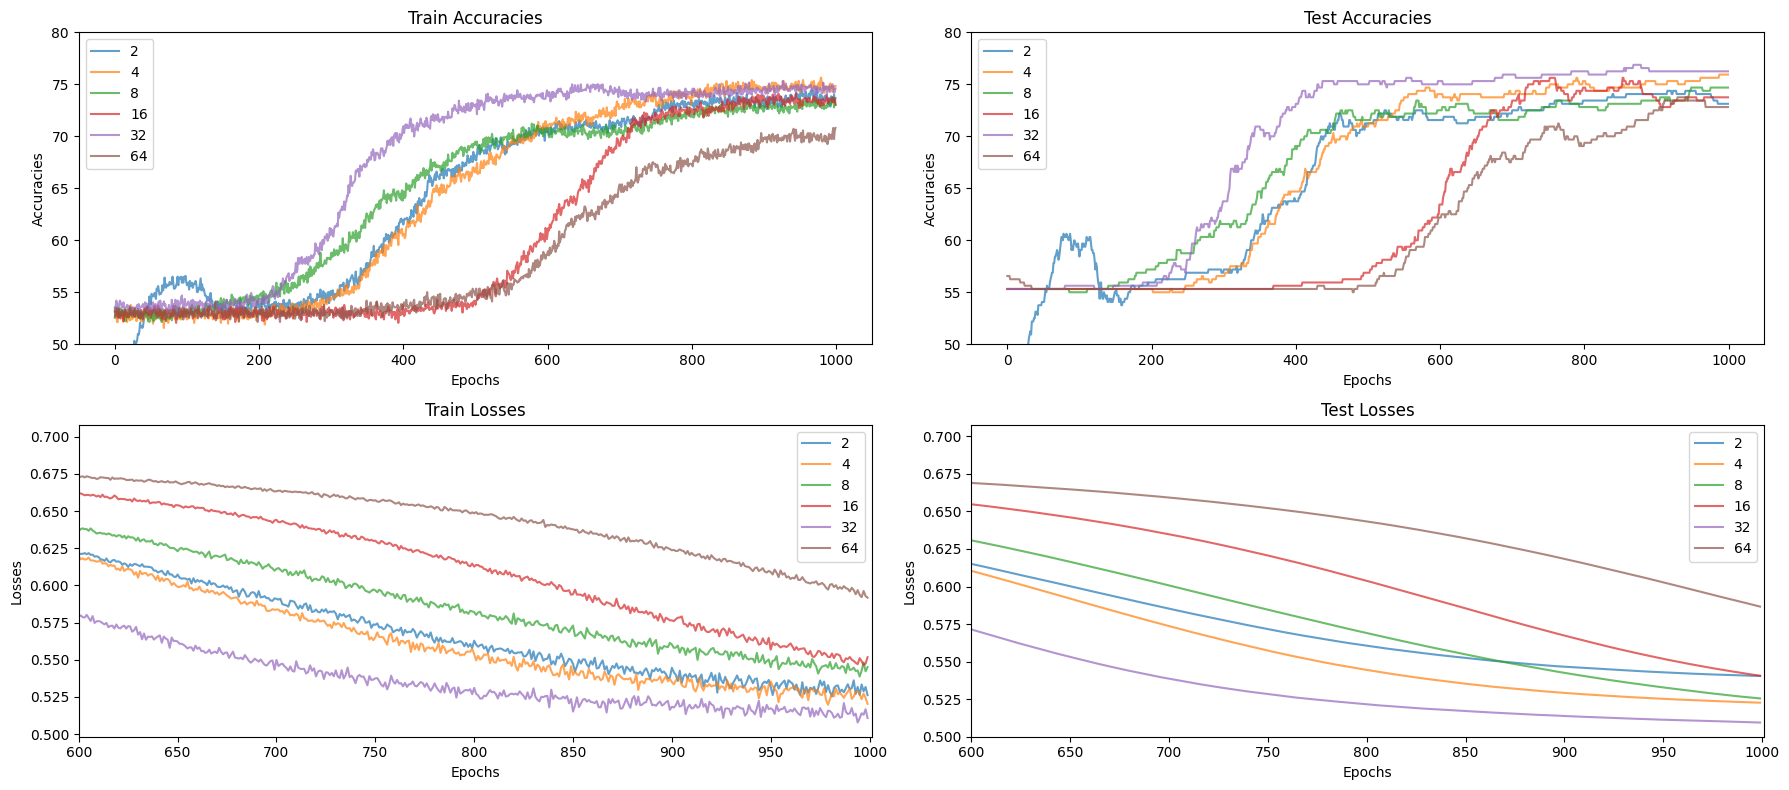

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (18, 8))

ax[0][0].plot(exp_train_accs, '-', markerfacecolor = 'w', alpha = .7)
ax[0][0].set_title('Train Accuracies')

ax[0][1].plot(exp_test_accs, '-', markerfacecolor = 'w', alpha = .7)
ax[0][1].set_title('Test Accuracies')

ax[1][0].plot(exp_train_losses.detach(), '-', markerfacecolor = 'w', alpha = .7)
ax[1][0].set_title('Train Losses')

ax[1][1].plot(exp_test_losses.detach(), '-', markerfacecolor = 'w', alpha = .7)
ax[1][1].set_title('Test Losses')

labels = [str(i) for i in batch_sizes]

for i in range(2):
  for j in range(2):
    ax[i][j].legend(labels)
    ax[i][j].set_xlabel('Epochs')

for i in range(2):
  ax[0][i].set_ylim([50, 80])
  ax[0][i].set_ylabel('Accuracies')

for i in range(2):
  ax[1][i].set_xlim([600, 1001])
  ax[1][i].set_ylabel('Losses')

plt.tight_layout()
plt.show()

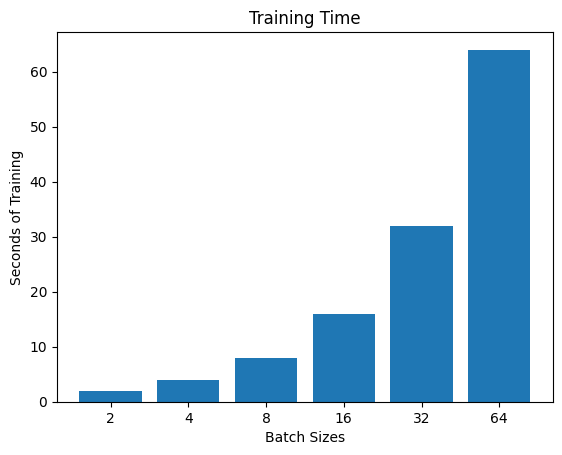

In [ ]:
plt.bar(range(len(exp_times)), batch_sizes, tick_label = batch_sizes)
plt.xlabel('Batch Sizes')
plt.ylabel('Seconds of Training')
plt.title('Training Time')
plt.show()